This file will do data separate. Since we plan to use one-class classification in general,  
we will preliminary cut some redundency features and separate it into these csv files:  
*"network_flow_regular_data.csv"*, *"network_flow_attack_data.csv"*, *"medical_regular_data.csv"*, and *"medical_attack_data.csv"*  

We focus on network flow data, it can be described by these two csv files:  
*"network_flow_regular_data.csv"* &nbsp; contains all network data with *Lable* = 0  
*"network_flow_attack_data.csv"* &nbsp; contains all network data with *Lable* = 1  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('../data/wustl-ehms-clean-2022.csv')
df.head()

,Dir,Flgs,SrcAddr,DstAddr,Sport,Dport,SrcBytes,DstBytes,SrcLoad,DstLoad,...,DstMac,Packet_num,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Label
0,->,e,10.0.1.172,10.0.1.150,58214,1111,496,186,180659.0,60220.0,...,b8:ca:3a:cf:0b:87,50,95,86,138,78,79,13,0.34,0
1,->,e,10.0.1.172,10.0.1.150,58218,1111,496,186,285030.0,95010.0,...,b8:ca:3a:cf:0b:87,51,94,83,138,78,79,13,0.34,0
2,->,e,10.0.1.172,10.0.1.150,58222,1111,496,186,200188.0,66729.0,...,b8:ca:3a:cf:0b:87,52,94,83,138,78,79,26,0.14,0
3,->,e,10.0.1.172,10.0.1.150,58224,1111,496,186,205738.0,68579.0,...,b8:ca:3a:cf:0b:87,53,93,81,138,78,79,26,0.14,0
4,->,e,10.0.1.172,10.0.1.150,58227,1111,496,186,106503.0,35501.0,...,b8:ca:3a:cf:0b:87,54,93,80,138,78,79,26,0.14,0


First step,  
We would like to drop all data features with the same value, which is "True" shown in previous dataframe.  
Because these are not important toward data structure.

In [2]:
# figure out irrelevant features
schema = df.apply(lambda col: [(col == col[0]).all()])
schema

,Dir,Flgs,SrcAddr,DstAddr,Sport,Dport,SrcBytes,DstBytes,SrcLoad,DstLoad,...,DstMac,Packet_num,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Label
0,True,False,True,True,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [3]:
# list all relevant columns
remain_cols = []
drop_cols = []
for col in schema.columns:
  if not schema[col][0]:
    remain_cols.append(col)
  else:
    drop_cols.append(col)

print("remain_cols: ", remain_cols, "with length", len(remain_cols))
print("drop_cols: ", drop_cols, "with length", len(drop_cols))

remain_cols:  ['Flgs', 'Sport', 'SrcBytes', 'DstBytes', 'SrcLoad', 'DstLoad', 'SIntPkt', 'DIntPkt', 'SIntPktAct', 'SrcJitter', 'DstJitter', 'sMaxPktSz', 'dMaxPktSz', 'sMinPktSz', 'Dur', 'TotPkts', 'TotBytes', 'Load', 'Loss', 'pLoss', 'pSrcLoss', 'pDstLoss', 'Rate', 'SrcMac', 'Packet_num', 'SpO2', 'Pulse_Rate', 'SYS', 'DIA', 'Heart_rate', 'Resp_Rate', 'ST', 'Label'] with length 33
drop_cols:  ['Dir', 'SrcAddr', 'DstAddr', 'Dport', 'SrcGap', 'DstGap', 'DIntPktAct', 'dMinPktSz', 'Trans', 'DstMac'] with length 10


In [4]:
# form a new data frame by selected columns above
ndf = df[remain_cols]
ndf.head()

,Flgs,Sport,SrcBytes,DstBytes,SrcLoad,DstLoad,SIntPkt,DIntPkt,SIntPktAct,SrcJitter,...,SrcMac,Packet_num,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Label
0,e,58214,496,186,180659.0,60220.0,5.491000,2.8145,0.0,4.466698,...,84:3a:4b:0f:5b:94,50,95,86,138,78,79,13,0.34,0
1,e,58218,496,186,285030.0,95010.0,3.480333,2.3295,0.0,2.516453,...,84:3a:4b:0f:5b:94,51,94,83,138,78,79,13,0.34,0
2,e,58222,496,186,200188.0,66729.0,4.955333,2.3725,0.0,4.186609,...,84:3a:4b:0f:5b:94,52,94,83,138,78,79,26,0.14,0
3,e,58224,496,186,205738.0,68579.0,4.821667,2.8240,0.0,3.677997,...,84:3a:4b:0f:5b:94,53,93,81,138,78,79,26,0.14,0
4,e,58227,496,186,106503.0,35501.0,9.314333,7.3005,0.0,6.594388,...,84:3a:4b:0f:5b:94,54,93,80,138,78,79,26,0.14,0


Then we find out the mean and variance of attacks data cases and normal data cases.  
This process helps us to figure out whether there exist obvious differences between two classes.  

In [5]:
stats=pd.DataFrame()
stats["mean"]=ndf.mean(numeric_only=True)
stats["Std.Dev"]=ndf.std(numeric_only=True)
stats["Var"]=ndf.var(numeric_only=True)
# stats.transpose()
stats

,mean,Std.Dev,Var
SrcBytes,496.685620,29.430507,8.661547e+02
DstBytes,187.138865,19.236607,3.700471e+02
SrcLoad,211102.639832,80208.746950,6.433443e+09
DstLoad,70803.092528,46351.516380,2.148463e+09
SIntPkt,11.264270,104.223097,1.086245e+04
DIntPkt,8.821741,54.032248,2.919484e+03
SIntPktAct,1.364607,63.970393,4.092211e+03
SrcJitter,33.680939,1304.021511,1.700472e+06
DstJitter,8.856874,51.105601,2.611782e+03
sMaxPktSz,310.000455,0.021324,4.546930e-04


We consider to drop some unimportant data that don't make sense.  
Such as packet_num, it just keep growing with the number of data case.  
Drop Network Flow features:  
*Flgs*  
*Sport*  
*SIntPktAct*  
*sMaxPktSz*   
*dMaxPktSz*  
*sMinPktSz*  
*Loss*   
*pLoss*   
*pSrcLoss*  
*pDstLoss*  
*Packet_num*  
*SrcMac*  
Below are steps to verify these features are redundent.

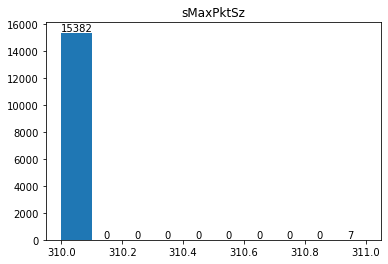

In [6]:
fig1 = plt.figure("Figure 1")
counts, edges, bars = plt.hist(ndf['sMaxPktSz'])
plt.bar_label(bars)
# bins, counts = np.histogram(ndf['sMaxPktSz'])
# plt.stairs(bins, counts)
# plt.xticks([310, 311])
plt.title("sMaxPktSz")
plt.show()

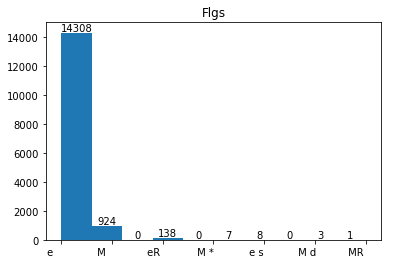

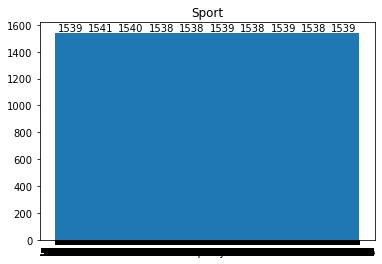

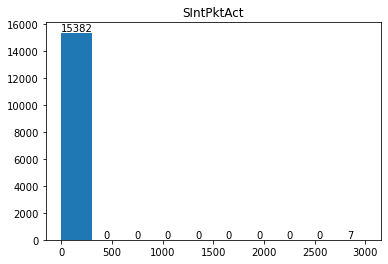

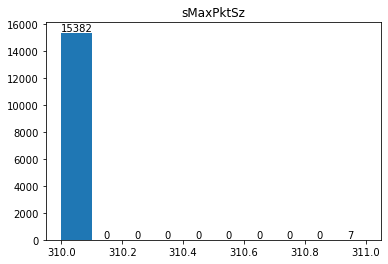

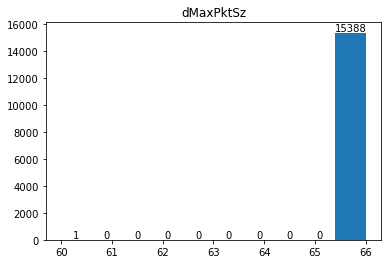

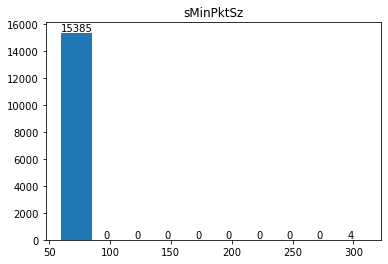

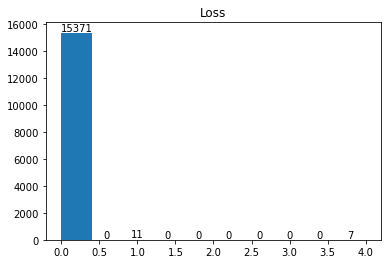

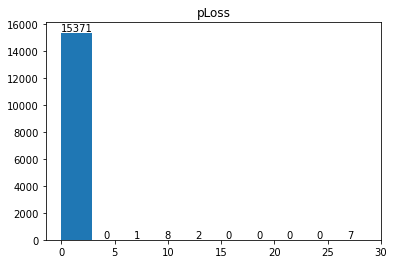

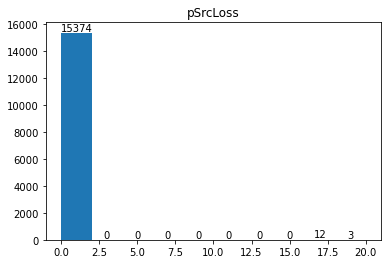

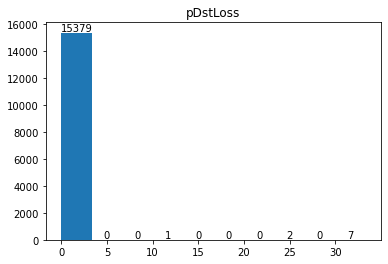

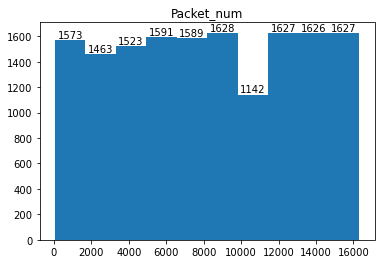

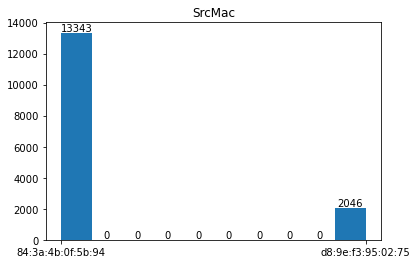

In [7]:
# figures = [plt.figure("Figure " + str(i)) for i in range(len(ndf))]
select_cols_2 = ['Flgs', 'Sport', 'SIntPktAct', 'sMaxPktSz', 'dMaxPktSz', 'sMinPktSz', 'Loss', 'pLoss', 'pSrcLoss', 'pDstLoss', 'Packet_num', 'SrcMac']

i = 0
for name in select_cols_2:
    fig = plt.figure("Figure " + str(i))
    counts, edges, bars = plt.hist(ndf[name])
    plt.bar_label(bars)
    plt.title(name)
    plt.show()
    i += 1

In [8]:
ndf.loc[ndf['Flgs'].str.contains('M') & ndf['Label'] == 1]

,Flgs,Sport,SrcBytes,DstBytes,SrcLoad,DstLoad,SIntPkt,DIntPkt,SIntPktAct,SrcJitter,...,SrcMac,Packet_num,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Label
56,M,58388,496,186,21394.000,7131.000,46.368000,41.8805,0.0,6.425858,...,d8:9e:f3:95:02:75,106,97,83,138,78,90,13,0.44,1
57,M,58391,496,186,20074.000,6691.000,49.416000,44.1970,0.0,10.082495,...,d8:9e:f3:95:02:75,107,98,84,138,78,90,13,0.44,1
58,M,58394,496,186,22537.000,7512.000,44.017332,42.7980,0.0,2.129140,...,d8:9e:f3:95:02:75,108,98,84,138,78,90,13,0.32,1
59,M,58397,496,186,19026.000,6342.000,52.139668,50.4060,0.0,2.943382,...,d8:9e:f3:95:02:75,109,98,85,138,78,90,13,0.32,1
60,M,58398,496,186,20160.000,6720.000,49.206668,42.1660,0.0,10.022406,...,d8:9e:f3:95:02:75,110,98,85,138,78,90,13,0.32,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14878,M,51167,496,186,21189.000,7063.000,46.816332,42.4980,0.0,6.349188,...,d8:9e:f3:95:02:75,15804,98,78,148,84,78,19,0.30,1
14879,M,51229,496,186,24202.000,8067.000,40.988332,37.6390,0.0,6.291200,...,d8:9e:f3:95:02:75,15805,98,78,148,84,78,19,0.30,1
14880,M,51392,496,186,21198.000,7066.000,46.797668,48.8090,0.0,2.850063,...,d8:9e:f3:95:02:75,15806,98,84,148,84,84,19,0.30,1
14881,M,51457,496,186,20476.000,6825.000,48.447332,46.5440,0.0,3.243485,...,d8:9e:f3:95:02:75,15807,98,73,148,84,73,19,0.30,1


Drop out selected columns and create a new dataframe.

In [9]:
drop_cols_2 = ['Flgs', 'Sport', 'SIntPktAct', 'sMaxPktSz', 'dMaxPktSz', 'sMinPktSz', 'Loss', 'pLoss', 'pSrcLoss', 'pDstLoss', 'Packet_num', 'SrcMac']

ndf2 = ndf.drop(drop_cols_2, axis=1)
ndf2.head()

,SrcBytes,DstBytes,SrcLoad,DstLoad,SIntPkt,DIntPkt,SrcJitter,DstJitter,Dur,TotPkts,...,Load,Rate,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Label
0,496,186,180659.0,60220.0,5.491000,2.8145,4.466698,2.7445,0.016473,7,...,240879.0,364.232,95,86,138,78,79,13,0.34,0
1,496,186,285030.0,95010.0,3.480333,2.3295,2.516453,2.2855,0.010441,7,...,380040.0,574.658,94,83,138,78,79,13,0.34,0
2,496,186,200188.0,66729.0,4.955333,2.3725,4.186609,2.3385,0.014866,7,...,266918.0,403.606,94,83,138,78,79,26,0.14,0
3,496,186,205738.0,68579.0,4.821667,2.8240,3.677997,2.7860,0.014465,7,...,274317.0,414.794,93,81,138,78,79,26,0.14,0
4,496,186,106503.0,35501.0,9.314333,7.3005,6.594388,7.2665,0.027943,7,...,142003.0,214.723,93,80,138,78,79,26,0.14,0


Now, we split dataset into Network Flow and Medical data.

In [10]:
regular_df = ndf2.loc[ndf2['Label'] == 0]
attack_df = ndf2.loc[ndf2['Label'] == 1]

regular_df.head()

,SrcBytes,DstBytes,SrcLoad,DstLoad,SIntPkt,DIntPkt,SrcJitter,DstJitter,Dur,TotPkts,...,Load,Rate,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Label
0,496,186,180659.0,60220.0,5.491000,2.8145,4.466698,2.7445,0.016473,7,...,240879.0,364.232,95,86,138,78,79,13,0.34,0
1,496,186,285030.0,95010.0,3.480333,2.3295,2.516453,2.2855,0.010441,7,...,380040.0,574.658,94,83,138,78,79,13,0.34,0
2,496,186,200188.0,66729.0,4.955333,2.3725,4.186609,2.3385,0.014866,7,...,266918.0,403.606,94,83,138,78,79,26,0.14,0
3,496,186,205738.0,68579.0,4.821667,2.8240,3.677997,2.7860,0.014465,7,...,274317.0,414.794,93,81,138,78,79,26,0.14,0
4,496,186,106503.0,35501.0,9.314333,7.3005,6.594388,7.2665,0.027943,7,...,142003.0,214.723,93,80,138,78,79,26,0.14,0


In [11]:
# Separate data into files
Y_regular = regular_df.iloc[:, -1]
X_net_reg = regular_df.iloc[:, :-8]
X_med_reg = regular_df.iloc[:, -8:-1]

network_flow_regular_data = pd.concat([X_net_reg, Y_regular], axis=1)
medical_regular_data = pd.concat([X_med_reg, Y_regular], axis=1)

network_flow_regular_data.to_csv('../data/network_flow_regular_data.csv', index=False)
medical_regular_data.to_csv('../data/medical_regular_data.csv', index=False)

In [12]:
Y_attack = attack_df.iloc[:, -1]
X_net_att = attack_df.iloc[:, :-8]
X_med_att = attack_df.iloc[:, -8:-1]

network_flow_attack_data = pd.concat([X_net_att, Y_attack], axis=1)
medical_attack_data = pd.concat([X_med_att, Y_attack], axis=1)

network_flow_attack_data.to_csv('../data/network_flow_attack_data.csv', index=False)
medical_attack_data.to_csv('../data/medical_attack_data.csv', index=False)

In [13]:
nfdf = ndf2.iloc[:, :-8]
nfdf = pd.concat([nfdf, ndf2.iloc[:, -1]], axis=1)
nfdf.to_csv('../data/nfdf.csv', index=False)

In [14]:
# try normalize
# scaler = preprocessing.MinMaxScaler()
# scaler.fit(X_reg_net)
# scaled = scaler.fit_transform(X_reg_net)
# X_net = pd.DataFrame(scaled, columns=X_reg_net.columns)

# X_net.to_csv('../data/norm_reg_X.csv')

# X_net.head()